In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [ ]:
train_data = pd.read_excel('../Data/train_data_prob_added.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../Data/test_data_prob_added.xlsx')
test_data = test_data.convert_dtypes()

In [3]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              36168 non-null  string 
 1   age            36168 non-null  Int64  
 2   balance        36168 non-null  Int64  
 3   day_of_month   36168 non-null  Int64  
 4   duration       36168 non-null  Int64  
 5   campaign       36168 non-null  Int64  
 6   pdays          36168 non-null  Int64  
 7   previous       36168 non-null  Int64  
 8   NB_prob        36168 non-null  Float64
 9   Logistic_prob  36168 non-null  Float64
 10  DT_prob        36168 non-null  Float64
 11  EBM_prob       36168 non-null  Float64
dtypes: Float64(4), Int64(7), string(1)
memory usage: 3.7 MB
None


In [4]:
display(train_data.head())
train_data.shape

,y,age,balance,day_of_month,duration,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,EBM_prob
0,yes,66,2048,27,212,1,-1,0,0.2548,0.590641,0.525657,0.336438
1,no,49,181,8,161,3,-1,0,0.012788,0.184176,0.286525,0.185477
2,no,41,-129,18,176,1,-1,0,0.020337,0.460129,0.403237,0.365158
3,no,42,1316,5,285,1,-1,0,0.070662,0.283496,0.286525,0.372153
4,no,45,1621,18,122,8,-1,0,0.095399,0.416171,0.525657,0.487318


(36168, 12)

## Continuous Covariates

In [16]:
numeric_cols = ["age","balance","pdays","previous","NB_prob","Logistic_prob","DT_prob"]
X_train = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()
y_train = (train_data['y'] == "yes").astype(int)
y_test = (test_data['y'] == "yes").astype(int)

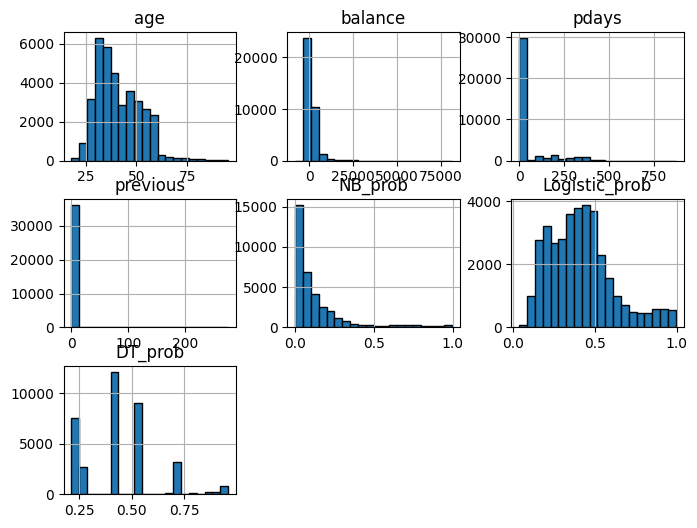

In [17]:
X_train.hist(bins = 20,edgecolor ='black',figsize=(8,6))
plt.show()

In [18]:
X_train["log_balance"] = np.sign(X_train["balance"]) * np.log1p(np.abs(X_train["balance"]))
X_train["log_previous"] = np.log1p(X_train["previous"])
X_test["log_balance"] = np.sign(X_test["balance"]) * np.log1p(np.abs(X_test["balance"]))
X_test["log_previous"] = np.log1p(X_test["previous"])

In [19]:
X_train.head()

,age,balance,pdays,previous,NB_prob,Logistic_prob,DT_prob,log_balance,log_previous
0,66,2048,-1,0,0.2548,0.590641,0.525657,7.625107,0.0
1,49,181,-1,0,0.012788,0.184176,0.286525,5.204007,0.0
2,41,-129,-1,0,0.020337,0.460129,0.403237,-4.867534,0.0
3,42,1316,-1,0,0.070662,0.283496,0.286525,7.183112,0.0
4,45,1621,-1,0,0.095399,0.416171,0.525657,7.391415,0.0


In [20]:
y_train.value_counts()

y
0    31936
1     4232
Name: count, dtype: int64

In [21]:
X_train = X_train.drop(["balance","previous"], axis=1)
X_test = X_test.drop(["balance","previous"], axis=1)

In [22]:
X_train.columns

Index(['age', 'pdays', 'NB_prob', 'Logistic_prob', 'DT_prob', 'log_balance',
       'log_previous'],
      dtype='object')

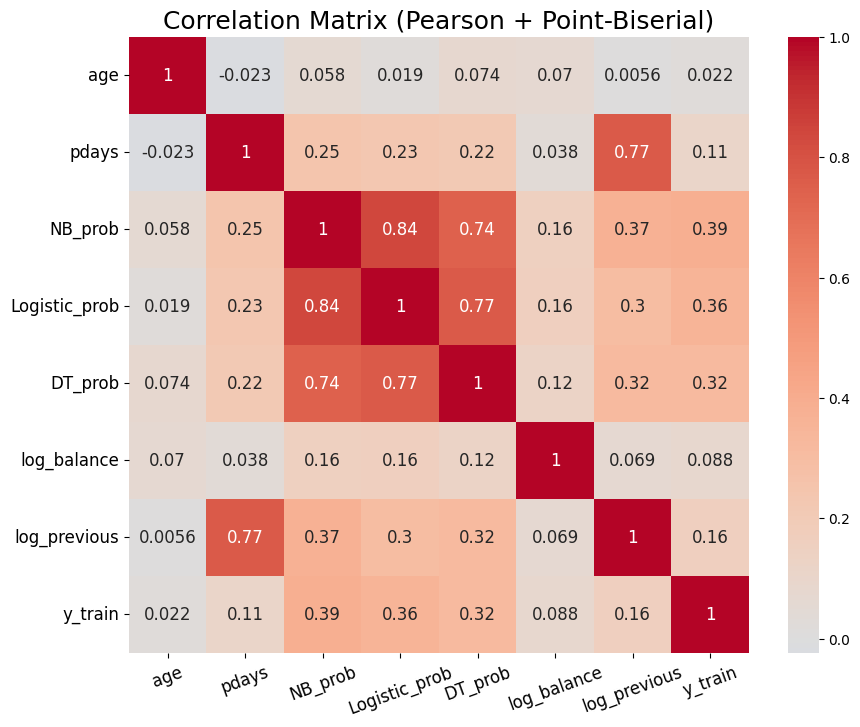

In [23]:
from scipy.stats import pointbiserialr

pb_corr = {}

for col in X_train.columns:
    r, p = pointbiserialr(y_train, X_train[col].astype(float))
    pb_corr[col] = r

pb_corr = pd.Series(pb_corr, name='y_train')

num_corr = X_train.corr()
corr = num_corr.copy()
corr['y_train'] = pb_corr
corr.loc['y_train'] = corr['y_train']
corr.loc['y_train','y_train'] = 1.0

plt.figure(figsize=(10,8))

sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    annot_kws={"size": 12}   # annotation (number) font size
)

plt.title("Correlation Matrix (Pearson + Point-Biserial)", fontsize=18)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [24]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob= None):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

In [27]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=0.001, class_weight="balanced"))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_metrics(y_test, y_pred)

Confusion Matrix:
 [[6838 1148]
 [ 487  570]]

Classification Report:
               precision    recall  f1-score   support

           0      0.934     0.856     0.893      7986
           1      0.332     0.539     0.411      1057

    accuracy                          0.819      9043
   macro avg      0.633     0.698     0.652      9043
weighted avg      0.863     0.819     0.837      9043



In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

# Define pipeline
def make_model(C):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="linear", C=C, class_weight="balanced"))
    ])

# Candidate C values
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results = {}
print("🔧 Starting C tuning...\n")

# Loop with tqdm progress bar
for C in tqdm(C_values, desc="Tuning SVM(C)", colour="green"):
    model = make_model(C)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1", n_jobs=-1)
    results[C] = np.mean(scores)

# Best C
best_C = max(results, key=results.get)
print("\n✅ Best C:", best_C)
print("📈 Best CV F1 Score:", results[best_C])

# Train final model
best_model = make_model(best_C)
best_model.fit(X_train, y_train)

# Evaluate
y_pred = best_model.predict(X_test)
print_metrics(y_test, y_pred)

🔧 Starting C tuning...



Tuning SVM(C): 100%|██████████| 6/6 [10:05<00:00, 101.00s/it]



✅ Best C: 0.001
📈 Best CV F1 Score: 0.41141322779268785
Confusion Matrix:
 [[6796 1190]
 [ 483  574]]

Classification Report:
               precision    recall  f1-score   support

           0      0.934     0.851     0.890      7986
           1      0.325     0.543     0.407      1057

    accuracy                          0.815      9043
   macro avg      0.630     0.697     0.649      9043
weighted avg      0.863     0.815     0.834      9043



In [15]:
results

{0.001: 0.41141322779268785,
 0.01: 0.406389287261047,
 0.1: 0.4054151667687025,
 1: 0.40561400798938857,
 10: 0.4056806288007853,
 100: 0.4051775810468654}

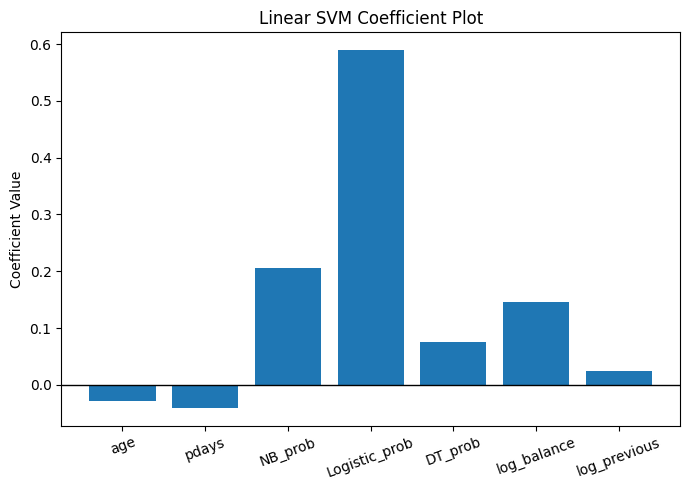

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coef = svm_model.named_steps["svc"].coef_[0]

plt.figure(figsize=(7,5))
plt.bar(list(X_train.columns), coef)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear SVM Coefficient Plot")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()